In [ ]:
#| hide
#| default_exp monitor
from nbdev import *

# Monitor

> Monitoring functions for HECSS sampler

In [ ]:
#| exporti
from numpy import sqrt, loadtxt, array, linspace, histogram
from numpy import median, abs, convolve, ones, arange, cumsum, fromiter
from IPython.display import clear_output
import subprocess
from time import sleep
from matplotlib import pyplot as plt
from matplotlib.pyplot import plot, figure, subplot, legend, show, sca, title
from matplotlib.pyplot import hist, semilogx, semilogy, axvspan, axhspan
from matplotlib.pyplot import xlabel, ylabel, xticks, xlim, ylim, axhline, axvline
from scipy import stats
import sys
from spglib import find_primitive, get_symmetry_dataset
from collections import Counter
from hecss.util import load_dfset, get_dfset_len

In [ ]:
#| exporti
from ase.data import chemical_symbols
from ase import units as un
THz = 1e12 * un._hplanck * un.J # THz in eV

In [ ]:
#| export
def plot_band_set(bnd, units=THz, lbl=None, **kwargs):
    if lbl is None:
        lbl=''
    kwa = {k:v for k, v in kwargs.items() if k not in ('color',)}
    plt=plot(bnd[0], un.invcm * bnd[1] / units, label=lbl, **kwargs)
    for b in bnd[2:]:
        plot(bnd[0], un.invcm * b / units, color=plt[0].get_color(), **kwa)

In [ ]:
#| export
def plot_bands(bnd, kpnts, units=THz, decorate=True, lbl=None, **kwargs):
    plot_band_set(bnd, units, lbl, **kwargs)

    lbls, pnts = kpnts

    if decorate:
        xticks(pnts, lbls)
        xlim(min(pnts), max(pnts))
        axhline(0,ls=':', lw=1, alpha=0.5)
        for p in sorted(pnts)[1:-1]:
            axvline(p, ls=':', lw=1, alpha=0.5)
        xlabel('Wave vector')
        ylabel('Frequency (THz)')

In [ ]:
#| export
def plot_bands_file(fn, units=THz, decorate=True, lbl=None, **kwargs):
    bnd = loadtxt(fn).T

    with open(fn) as f:
        p_lbl = [l if l!='G' else '$\\Gamma$' for l in f.readline().split()[1:]]
        p_pnt = [float(v) for v in f.readline().split()[1:]]
    kpnts = (p_lbl, p_pnt)

    if lbl is None:
        lbl=fn

    plot_bands(bnd, kpnts, units, decorate, lbl, **kwargs)

In [ ]:
#| export
def run_alamode(d='phon', prefix='cryst', kpath='cryst', dfset='DFSET', sc='../sc/CONTCAR',
                o=1, n=0, c2=10, born=None, charge=None):
    fit_cmd = f'/home/jochym/Projects/alamode-tools/devel/make-gen.py opt -p {prefix} -n {sc} -f {dfset} -o {o} --c2 {c2} -d {n}'.split()
    b = ''
    if charge is None:
        charge = prefix
    if born is not None:
        b = f'-b {born} -c {charge}'
    phon_cmd = f'/home/jochym/Projects/alamode-tools/devel/make-gen.py phon -p {prefix} -n {sc} {b} -k {kpath}.path'.split()
    alm_cmd = f'/home/jochym/public/bin/alm {prefix}_fit.in'.split()
    anph_cmd = f'/home/jochym/public/bin/anphon {prefix}_phon.in'.split()

    with open(f'{d}/{prefix}_fit.in', 'w') as ff:
        fit = subprocess.run(fit_cmd, cwd=d, stdout=ff, stderr=subprocess.PIPE)

    with open(f'{d}/{prefix}_phon.in', 'w') as ff:
        phon = subprocess.run(phon_cmd, cwd=d, stdout=ff, stderr=subprocess.PIPE)

    alm = subprocess.run(alm_cmd, cwd=d, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    anph = subprocess.run(anph_cmd, cwd=d, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    for p, l in zip((fit, phon, alm, anph), ('fit', 'phon', 'alm', 'anphon')):
        if p.stdout is not None:
            with open(f'{d}/{prefix}_{l}.log', 'wt') as lf:
                lf.write(p.stdout.decode())
        if p.stderr is not None and len(p.stderr) > 0:
            with open(f'{d}/{prefix}_{l}.err', 'wt') as lf:
                lf.write(p.stderr.decode())

    return all([r.returncode==0 for r in  (fit, phon, alm, anph)]), fit, phon, alm, anph

In [ ]:
#| export
def show_dc_conv(bl, kpnts, max_plots=4):
    prev_n = sorted(bl.keys())[-1]
    plot_bands(bl[prev_n], kpnts, lbl=f'{prev_n}', color='C3')
    y_lims = ylim()
    alpha = 1
    plotted = 1
    for n in reversed(sorted(bl.keys())):
        if n > prev_n*0.75 :
            continue
        alpha *= 0.8
        plot_band_set(bl[n], lbl=f'{n}', alpha=alpha, color='C0', ls='--', lw=1)
        plotted += 1
        prev_n = n
        if plotted > max_plots :
            break
    ylim(y_lims)
    legend()

In [ ]:
#| export
def build_bnd_lst(directory='phon', dfset='DFSET', prefix='cryst', kpath='crast', sc='../sc/CONTCAR',
                  order=1, cutoff=10, born=None, charge=None, verbose=False):
    N = get_dfset_len(f'{directory}/{dfset}')
    bl = {}
    for n in range(1,N+1):
        if verbose :
            print(f'Using first {n:3} samples', end='\n')
        run_alamode(d=directory, prefix=prefix, dfset=dfset, kpath=kpath, sc=sc,
                    o=order, n=n, c2=cutoff, born=born, charge=charge)
        bl[n]=loadtxt(f'{directory}/{prefix}.bands').T
    if verbose :
        print()
    return bl

In [ ]:
#| export
def build_omega(bl, kpnts):
    omega={}
    eps=1e-3
    kp_dict = {k:v for k,v in zip(*kpnts)}
    for k,v in kp_dict.items():
        omega[k] = array([[n] + list(bnd[1:,abs(bnd[0]-v)<eps][:,0]) for n, bnd in sorted(bl.items())]).T
        omega[k][1:] = omega[k][1:,-1][:,None] - omega[k][1:]
    return omega

In [ ]:
#| export
def plot_omega(omega):
    for k, o in omega.items():
        if len(o[0])<2 :
            return
        l = k
        if k == 'G':
            l = '$\\Gamma$'
        semilogy(o[0, :-1], (un.invcm * o[1:,:-1].std(axis=0))/THz, '-', label=l)

    legend()
    plt.gca().set_xscale('function', functions=(lambda x: x**(1/2), lambda x: x**2))
    rng = 10*un.invcm*median([o[1:].std(axis=0) for o in omega.values()])/THz
    if rng > 1e-3:
        ylim(None, rng)
    #axhline(0, ls=':', lw=1)
    ylabel('Frequency convergence (THz)')
    xlabel('Number of samples')

In [ ]:
#| export
def monitor_phonons(directory='phon', dfset='DFSET', prefix='cryst', kpath='cryst', sc='../sc/CONTCAR',
                    order=1, cutoff=10, born=None, charge=None, k_list=None, 
                    fig_out=None, once=False):

    def update_fig(fig, bnd_lst, kpnts, k_lst):
        if fig is not None:
            plt.close(fig)
        fig = figure(figsize=(14,5))
        (dcplt, omplt) = fig.subplots(1, 2)
        sca(dcplt)
        show_dc_conv(bnd_lst, kpnts)
        sca(omplt)
        if N>1:
            if k_lst is None:
                plot_omega(build_omega(bnd_lst, kpnts))
            else :
                plot_omega(build_omega(bnd_lst,
                                        ([l for l in kpnts[0] if l in k_lst],
                                         [v for l, v in zip(*kpnts) if l in k_lst])))
        show()
        clear_output(wait=True)
        return fig

    bnd_lst = {}

    if get_dfset_len(f'{directory}/{dfset}') < 1:
        print('Waiting for the first sample.', end='')
        sys.stdout.flush()
        while get_dfset_len(f'{directory}/{dfset}') < 1:
           sleep(15)
           print('.', end='')
           sys.stdout.flush()
        print('done.', end='')
    print('Calculating the plots.',)
    sys.stdout.flush()
    clear_output(wait=True)

    N = get_dfset_len(f'{directory}/{dfset}')
    run_alamode(d=directory, dfset=dfset, prefix=prefix, kpath=kpath, sc=sc,
                o=order, n=N, c2=cutoff, born=born, charge=charge)
    bnd_lst[N] = loadtxt(f'{directory}/{prefix}.bands').T
    prev_N = N

    with open(f'{directory}/{prefix}.bands') as f:
        p_lbl = [v if v!='G' else '$\\Gamma$' for v in f.readline().split()[1:]]
        p_pnt = [float(v) for v in f.readline().split()[1:]]
    kpnts = (p_lbl, p_pnt)

    fig = update_fig(None, bnd_lst, kpnts, k_list)
    if fig_out is not None :
        fig_out.append(fig)

    while True :
        N = get_dfset_len(f'{directory}/{dfset}')
        if N > prev_N:
            r = run_alamode(d=directory, dfset=dfset, prefix=prefix, kpath=kpath, sc=sc,
                            o=order, n=N, c2=cutoff, born=born, charge=charge)
            if r[0]:
                bnd_lst[N] = loadtxt(f'{directory}/{prefix}.bands').T
                fig = update_fig(fig, bnd_lst, kpnts, k_list)
                if fig_out is not None :
                    fig_out[-1]=fig
                prev_N = N
        else :
            SN = N//2
            all_done = True
            while SN > 0:
                for NN in range(N, 1, -SN):
                    if NN not in bnd_lst:
                        all_done = False
                        r = run_alamode(d=directory, dfset=dfset, prefix=prefix, kpath=kpath, sc=sc,
                                        o=order, n=NN, c2=cutoff, born=born, charge=charge)
                        if r[0]:
                            bnd_lst[NN] = loadtxt(f'{directory}/{prefix}.bands').T
                            fig = update_fig(fig, bnd_lst, kpnts, k_list)
                            if fig_out is not None :
                                fig_out[-1]=fig
                    if get_dfset_len(f'{directory}/{dfset}') > prev_N:
                        SN = 0
                        all_done = False
                        break
                SN = SN//2
            if all_done:
                if once :
                    break
                sleep(30)

In [ ]:
#| export
def plot_stats(confs, T=None, sqrN=False, show=True, 
               plotchi2=False, show_samples=True):
    '''
    Plot monitoring histograms for the configuration list in confs.
    If len(confs)<3 this function is silent.

    confs - configuration list
    T     - target temperature in Kelvin
    show  - call show() fuction at the end (default:True)
    show_samples - show individual samples above the histogram
    '''

    if len(confs) < 3:
        return

    #E0 = Vasp2(restart=base_dir+'/../calc/').get_potential_energy()
    #es = [(Vasp2(restart=d).get_potential_energy()-E0)/nat
    #          for d in sorted(glob(base_dir+'/../calc/T_600.0K/smpl/0*/'))]
    
    es = fromiter((_[-1] for _ in confs), float)

    if T is None:
        T = 2*es.mean()/3/un.kB
    
    nat = confs[0][-3].shape[0]
    
    E_goal = 3*T*un.kB/2
    Es = sqrt(3/2)*un.kB*T/sqrt(nat)
    e = linspace(E_goal - 3*Es, E_goal + 3*Es, 200)
    n = len(es)
    us = list(set(es))

    plt.hist(es, bins='auto', density=False, label=f'{n}({len(us)}) samples', alpha=0.5, rwidth=0.4, zorder=0)
    h = histogram(es, bins='auto', density=False)
    de = (h[1][-1]-h[1][0])/len(h[0])
    N = len(es)
    if sqrN :
        plt.errorbar((h[1][:-1]+h[1][1:])/2, h[0],
                     yerr=sqrt(h[0]), fmt='+', color='C0', alpha=0.66,
                     capsize=6, label='$\\pm\\sqrt{n}$')
        # plt.errorbar((h[1][:-1]+h[1][1:])/2, h[0],
        #              yerr=2*sqrt(h[0]), fmt='+', color='C0', alpha=0.33,
        #              capsize=4, label='$2/\\sqrt{N}$')

    plt.axvline(E_goal, ls='--', color='C2', label=f'Target energy {T:.2f} K')
    pdf = N*de*stats.norm.pdf(e, E_goal, Es)
    plt.fill_between(e,  (pdf-sqrt(pdf)).clip(min=0), pdf+sqrt(pdf), label='$\\sigma, 2\\sigma, 3\\sigma$', color='C1', alpha=0.1, zorder=9)
    plt.fill_between(e,  (pdf-2*sqrt(pdf)).clip(min=0), pdf+2*sqrt(pdf), color='C1', alpha=0.1, zorder=9)
    plt.fill_between(e,  (pdf-3*sqrt(pdf)).clip(min=0), pdf+3*sqrt(pdf), color='C1', alpha=0.1, zorder=9)
    plt.plot(e, pdf, '--', color='C1', label='Target normal dist.')
    fit = stats.norm.fit(es)
    plt.plot(e,  N*de*stats.norm.pdf(e, *fit), '--', color='C3', label='Fitted normal dist.', zorder=10)
    if plotchi2 :
        fit = stats.chi2.fit(es, f0=3*nat)
        plt.plot(e,  stats.chi2.pdf(e, *fit), '--', color='C4', label='Fitted $\\chi^2$ dist.', zorder=10)
        
    if show_samples:
        skip = len(us)//2000
        skip = int(max(1, skip))
        a = sqrt(2/(len(us)//skip))
        a = max(a, 0.01)
        a = min(a, 1)
        for s in us[::skip]:
            plt.axvline(s, ymin=0.97, ymax=0.99, 
                        ls='-', lw=1, color='r', alpha=a)
     
    plt.xlabel('Potential energy (meV/at)')
    plt.ylabel('Samples')
    plt.xlim(E_goal-3*Es,E_goal+3*Es)
    plt.legend(loc='upper right', bbox_to_anchor=(1.08, 0.965))
    if show :
        plt.show()

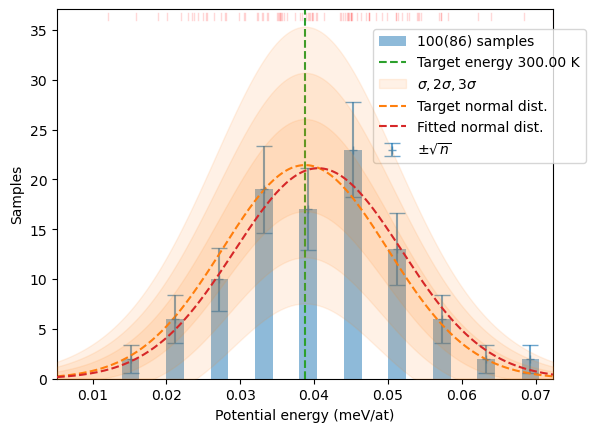

In [ ]:
plot_stats(load_dfset('example/VASP_3C-SiC_calculated/1x1x1/T_300K/DFSET.dat'), 
           T=300, sqrN=True)

In [ ]:
#| export
def monitor_stats(T, dfset, plotchi2=False, sqrN=False, once=False):

    prev_N = get_dfset_len(dfset)-1

    if get_dfset_len(dfset) < 3:
        print('Waiting for the first samples (>2).', end='')
        sys.stdout.flush()
        while get_dfset_len(dfset) < 3:
           sleep(15)
           print('.', end='')
           sys.stdout.flush()
        print('done.', end='')
    print('Calculating the plots.',)
    sys.stdout.flush()
    clear_output(wait=True)

    while True :
        N = get_dfset_len(dfset)
        if N > prev_N :
            plot_stats(load_dfset(dfset), T=T, plotchi2=plotchi2, sqrN=sqrN)
            show()
            if once:
                break
            clear_output(wait=True)
            prev_N = N
        else :
            sleep(15)

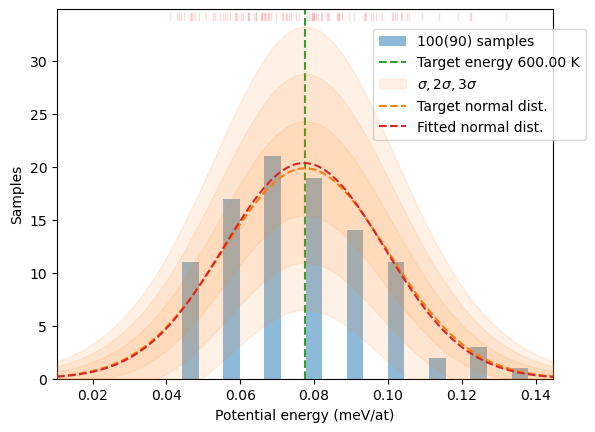

In [ ]:
monitor_stats(T=600, 
              dfset='example/VASP_3C-SiC_calculated/1x1x1/T_600K/DFSET.dat', 
              once=True)

In [ ]:
#| export

def moving_average(x, w):
    return convolve(x, ones(w), 'valid') / w

In [ ]:
#| export
def ewma(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [ ]:
#| export

def plot_hist(v, el, n, l='', alpha=0.2, normal=True, df=3):
    if normal:
        rfun = stats.norm
    else:
        rfun = stats.chi2
    hist(v, label=f'{el}{l}', bins='auto', color=f'C{n}', alpha=alpha, density=True)
    if normal or df is None:
        fit = rfun.fit(v)
    else:
        fit = rfun.fit(v, f0=df)
    m = v.mean()
    s = v.std()
    axvline(m if normal else fit[1]+max(fit[0]-2,0)*fit[2], ls='--', color=f'C{n}', label=f'{el}{l} = {m:.2f}±{s:.2f}')
    if normal:
        x = linspace(m-3*s, m+3*s, 100)
    else:
        x = linspace(0, m+3*s, 100)
    plot(x, rfun.pdf(x, *fit), ls='-', lw=1, color=f'C{n}', alpha=alpha+0.1)
    if normal:
        xlim(m-3*s, m+3*s)
    else:
        xlim(max(0, m-3*s), m+3*s)
    return m, s

In [ ]:
#| export

def plot_virial_stat(cryst, smpl, T, normal=False):
    elems = cryst.get_chemical_symbols()
    vir = array([abs(s[2]*s[3]) for s in smpl])/(un.kB*T)
    nat = len(elems)
    m, s = plot_hist(vir.mean(axis=(-1,-2)), 'Total', 0, normal=True)
    for n, el in enumerate(set(elems)):
        elmask = array(elems)==el
        plot_hist(vir[:, elmask, :].mean(axis=(-1,-2)), 
                  el, n+1, normal=normal, df=3*sum(elmask))
    axvline(T/T, ls=':', color='C5', label=f'{T:.0f} K')
    xlim(m - 5*s, m + 7*s)
    legend()
    title('Virial distribution in the sample')
    ylabel('Probability density')
    xlabel('Virial/Temperature');

In [ ]:
#| export

def plot_acceptance_history(smpl):
    figure(figsize=(10,4))
    na = array([n for i, n, x, f, e in smpl])
    na = cumsum((na[1:]-na[:-1])%2)
    plot(100*(na/arange(1,len(na)+1))[1:])
    xlabel('Step')
    ylabel('Acceptance ratio (approx., %)');

In [ ]:
#| export

def plot_dofmu_stat(cryst, dofmu, skip=10, window=10, normal=False):
    symm = get_symmetry_dataset(cryst)
    dofmap = symm['mapping_to_primitive']
    dof = set(dofmap)
    dofmul = Counter(symm['mapping_to_primitive'])
    elems = dict(zip(symm['std_mapping_to_primitive'],symm['std_types']))
    elmap = array(sorted(elems.items())).T
    xdof = array(dofmu)
    skip = min(skip, len(dofmu)//2)
    window = min(window, len(dofmu)//2)

    figure(figsize=(10,4))

    for i, el in enumerate(set(elmap[1])):
        n = len(xdof)
        elmask = elmap[1]==el
        semilogy()
        plot(xdof[:,elmask,:].reshape((-1,3*sum(elmask))),
                 '.', color=f'C{i}', ms=1, alpha=0.2)

        asx = moving_average(xdof[:,elmask,:].mean((-1,-2)), window)
        plot((n-len(asx))//2+arange(len(asx)), asx, '--',
                 label=f'{chemical_symbols[el]} (ma, w={window})', color=f'C{i}');

        asx = ewma(xdof[:,elmask,:].mean((-1,-2)), window)
        plot((n-len(asx))//2+arange(len(asx)), asx, 
                 label=f'{chemical_symbols[el]} (ewma, w={window})', color=f'C{i}');

    axvspan(0, skip, color='k', alpha=0.2)
    title('Virial history')
    xlabel('Steps')
    ylabel('Virial/Temperature V$_{DOF}$/T')
    legend();
    show();

    mi, ma = -1, -1

    for i, el in enumerate(set(elmap[1])):
        elmask = elmap[1]==el
        m, s = plot_hist(xdof[skip:,elmask,:].mean((-2, -1)), 
                         chemical_symbols[el], i,
                         normal=normal, df=3*sum(elmask))
        if mi < 0 or mi > m-3*s:
            mi = m-3*s
        if ma < 0 or ma < m+4*s:
            ma = m+4*s
    legend();
    xlim(mi, ma)
    title('Virial distribution')
    ylabel('Probability density')
    xlabel('Virial/Temperature')
    show() ;

In [ ]:
#| export

def plot_xs_stat(cryst, xsl, skip=10, window=10):
    symm = get_symmetry_dataset(cryst)
    dofmap = symm['mapping_to_primitive']
    dof = set(dofmap)
    dofmul = Counter(symm['mapping_to_primitive'])
    elems = dict(zip(symm['std_mapping_to_primitive'],symm['std_types']))
    elmap = array(sorted(elems.items())).T
    elmap = cryst.get_atomic_numbers()
    xdof = array(xsl)
    skip = min(skip, len(xsl)//2)
    window = min(window, len(xsl)//2)

    plt.figure(figsize=(10,4))

    for i, el in enumerate(set(elmap)):
        n = len(xdof)
        plot(xdof[:,elmap==el,:].mean((-2,-1)),
                 '.', color=f'C{i}', ms=2, alpha=0.25)

        asx = moving_average(xdof[:,elmap==el,:].mean((-1,-2)), window)
        plot((n-len(asx))//2 + arange(len(asx)), asx, '--',
                 label=f'{chemical_symbols[el]} (ma, w={window})', color=f'C{i}');

        asx = ewma(xdof[:,elmap==el,:].mean((-1,-2)), window)
        plot((n-len(asx))//2 + arange(len(asx)), asx, 
                 label=f'{chemical_symbols[el]} (ewma, w={window})', color=f'C{i}');

    axvspan(0, skip, color='k', alpha=0.2)

    title('Amplitude correction history')
    xlabel('Steps')
    ylabel('Virial/Temperature V$_{DOF}$/T')
    legend();
    show();

    mi, ma = -1, -1
    for i, el in enumerate(set(elmap)):
        m, s = plot_hist(xdof[skip:,elmap==el,:].mean((-2,-1)), 
                  chemical_symbols[el], i)
        if mi < 0 or mi > m-3*s:
            mi = m-3*s
        if ma < 0 or ma < m+3*s:
            ma = m+3*s
    legend();
    xlim(mi, ma)
    title('Amplitude correction distribution')
    ylabel('Probability density')
    xlabel('Virial/Temperature')
    show() ;